<a href="https://colab.research.google.com/github/Yuyang-Cao/UQ/blob/main/UQ1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Purpose of this code is to examine how Bayes By Backprop and Laplacian Approximation works on a toy dataset. I chose Gaussian process since its predictive probability distribution has a closed form and thus is more convenient for next steps: computing how they perform regarding new data points.

In [1]:
import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [ ]:
!pip install laplace-torch
from laplace import Laplace

Create a gaussian process with exp. quardratic kernel, lengthscale 0.1 for a more curved function.

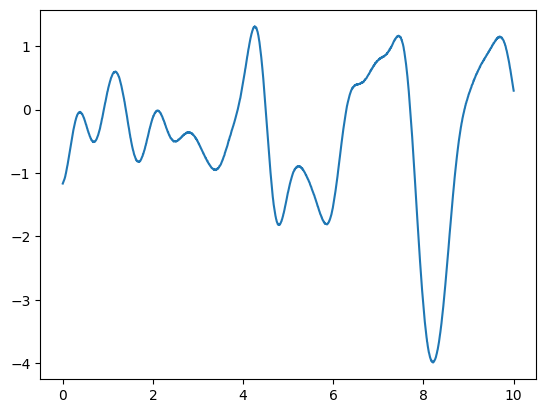

In [115]:
torch.set_default_dtype(torch.float32)

x = torch.from_numpy(np.linspace(0,10,2000)).float()
k = torch.exp(-0.5*(torch.pow(x[:,None]- x,2)/0.1))
k += torch.eye(k.shape[0])*1e-05
mn = torch.distributions.MultivariateNormal(torch.zeros(2000), k)
y = mn.sample()
plt.plot(x.detach(), y.detach())
X = x.reshape(-1,1)
Y = y.reshape(-1,1)

Now we construct a Bayesian neural network with bayesian weights

In [122]:
#This is the class for one BNN layer
class BNNLayer(nn.Module):
    NegHalfLog2PI = -.5 * math.log(2.0 * math.pi)
    softplus = lambda x: math.log(1 + math.exp(x))

    def __init__(self, n_input, n_output, activation, prior_mean, prior_rho):
        assert activation in {'relu', 'softmax', 'none'}, 'Activation Type Not Found'

        super(BNNLayer, self).__init__()

        # Instantiate a large Gaussian block to sample from, much faster than generating random sample every time
        self._gaussian_block = np.random.randn(10000)

        self.n_input = n_input
        self.n_output = n_output

        # Initialize the mean and std for means and bias for all the weights of the hidden units in our BNN
        # Implementation is the same as in the original paper for BNN except the prior, where we used only 1 instead of 2 for simplicity
        # More priors can be implemented as a Ensemble method later
        self.W_mean = nn.Parameter(torch.ones((n_input, n_output)) * prior_mean)
        self.W_rho = nn.Parameter(torch.ones(n_input, n_output) * prior_rho)

        self.b_mean = nn.Parameter(torch.ones(1, n_output) * prior_mean)
        self.b_rho = nn.Parameter(torch.ones(1, n_output) * prior_rho)

        self.prior_var = Variable(torch.ones(1, 1) * BNNLayer.softplus(prior_rho) ** 2)

        # Set activation function
        self.act = None
        if activation == 'relu':
            self.act = F.relu
        elif activation == 'softmax':
            self.act = F.softmax

        self._Var = lambda x: Variable(torch.from_numpy(x).type(torch.FloatTensor))

    def forward(self, X, mode):
        assert mode in {'forward', 'MAP', 'MC'}, 'BNNLayer Mode Not Found'

        _shape = (X.size()[0], self.n_output)

        # Z: pre-activation. Local reparam. trick is used.
        Z_Mean = torch.mm(X, self.W_mean) + self.b_mean.expand(*_shape)

        if mode == 'MAP': return self.act(Z_Mean) if self.act is not None else Z_Mean

        # Calculate the posterior std for calculating log likelihood of the posterior
        Z_Std = torch.sqrt(
            torch.mm(torch.pow(X, 2),
                     torch.pow(F.softplus(self.W_rho), 2)) +
            torch.pow(F.softplus(self.b_rho.expand(*_shape)), 2)
        )

        Z_noise = self._random(_shape)
        Z = Z_Mean + Z_Std * Z_noise

        if mode == 'MC': return self.act(Z) if self.act is not None else Z

        # Std for the prior
        Prior_Z_Std = torch.sqrt(
            torch.mm(torch.pow(X, 2),
                     self.prior_var.expand(self.n_input, self.n_output)) +
            self.prior_var.expand(*_shape)
        ).detach()

        # KL divergence between posterior and prior
        layer_KL = self.sample_KL(Z,
                                  Z_Mean, Z_Std,
                                  Z_Mean.detach(), Prior_Z_Std)

        out = self.act(Z) if self.act is not None else Z
        return out, layer_KL

    def _random(self, shape):
        Z_noise = np.random.choice(self._gaussian_block, size=shape[0] * shape[1])
        Z_noise = np.expand_dims(Z_noise, axis=1).reshape(*shape)
        return self._Var(Z_noise)

    @staticmethod
    def log_gaussian(x, mean, std):
        return BNNLayer.NegHalfLog2PI - torch.log(std) - .5 * torch.pow(x - mean, 2) / torch.pow(std, 2)

    @staticmethod
    def sample_KL(x, mean1, std1, mean2, std2):
        log_prob1 = BNNLayer.log_gaussian(x, mean1, std1)
        log_prob2 = BNNLayer.log_gaussian(x, mean2, std2)
        return (log_prob1 - log_prob2).sum()

# This is the implementation for the whole BNN
class BNN(nn.Module):
    def __init__(self, *layers):
        super(BNN, self).__init__()

        self.layers, self.params = [], nn.ParameterList()
        for layer in layers:
            self.layers.append(layer)
            self.params.extend([*layer.parameters()])

    def forward(self, x, mode):
        if mode == 'forward':
            net_kl = 0
            for layer in self.layers:
                x, layer_kl = layer.forward(x, mode)
                net_kl += layer_kl
            return x, net_kl
        else:
            for layer in self.layers:
                x = layer.forward(x, mode)
            return x

    def Forward(self, x, y, n_samples, type):

        assert type in {'Gaussian', 'Softmax'}, 'Likelihood type not found'
        total_kl, total_likelh = 0., 0.
        for _ in range(n_samples):
            out, kl = self.forward(x, mode='forward')

            if type == 'Gaussian':
                lklh = (-.5 * (y - out) ** 2).sum()
            else:
                lklh = torch.log(out.gather(1, y)).sum()

            total_kl += kl
            total_likelh += lklh

        return total_kl / n_samples, total_likelh / n_samples

    @staticmethod
    def loss_fn(kl, lklh, n_batch):
        return (kl / n_batch - lklh).mean()

In [123]:
bnn = BNN(BNNLayer(1, 50, 'relu', 0, 0), BNNLayer(50, 1, 'none', 0, 0))
x = x.reshape(-1,1)
y = y.reshape(-1,1)

In [ ]:
optim = torch.optim.Adam(bnn.parameters())

for i in range(5001):
  kl, lg_lklh = bnn.Forward(X, Y, 1, 'Gaussian')
  loss = BNN.loss_fn(kl, lg_lklh, 1)
  optim.zero_grad()
  loss.backward()
  optim.step()
  if i % 100 == 0:
    print(i,":")
    print(kl)
    print(lg_lklh)
    print(loss)

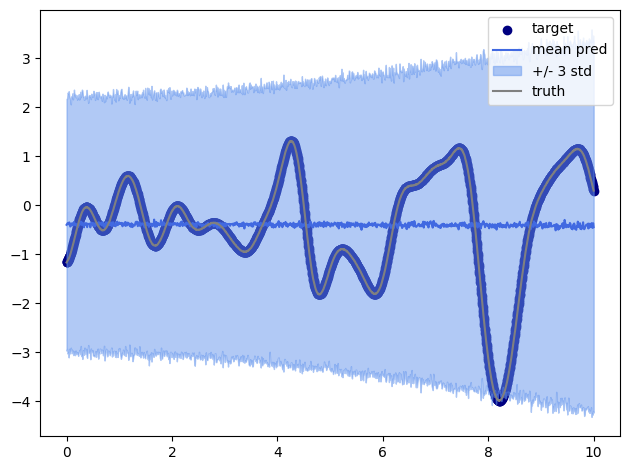

In [127]:
Var = lambda x, dtype=torch.FloatTensor: Variable(torch.from_numpy(x).type(dtype))
x_ = np.linspace(0,10,1000)
X_ = Var(x_).unsqueeze(1)

pred_lst = [bnn.forward(X_, mode='MC').data.numpy().squeeze(1) for _ in range(1000)]

pred = np.array(pred_lst).T
pred_mean = pred.mean(axis=1)
pred_std = pred.std(axis=1)

plt.scatter(X, Y, c='navy', label='target')

plt.plot(x_, pred_mean, c='royalblue', label='mean pred')
plt.fill_between(x_, pred_mean - 3 * pred_std, pred_mean + 3 * pred_std, color='cornflowerblue', alpha=.5, label='+/- 3 std')


plt.plot(X, Y, c='grey', label='truth')
plt.legend()
plt.tight_layout()
plt.show()

Seems like BNN doesn't perform too well on this dataset. With higher lengthscale, the function becomes more flat and BNN performs better, and with further examination, the weights of a regular NN that converges to this function has mean 0, variance 1 but a few particularly big numbers, which cannot happen for a BNN, thus the ensemble method with more varying priors should work much better.

This is a regular neural network instead of a Bayesian one, this is used as the base model for Laplace Approximation.

In [128]:
class NN(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(1,50),
        nn.ReLU(),
        nn.Linear(50,1)
        )

  def forward(self, x):
    z = self.net(x)
    return z

net = NN()
optim = torch.optim.Adam(net.parameters())

for i in range(20001):
  net.train()
  z = net(X).reshape(Y.shape)
  loss = ((z-Y)**2).sum()
  optim.zero_grad()
  loss.backward()
  optim.step()

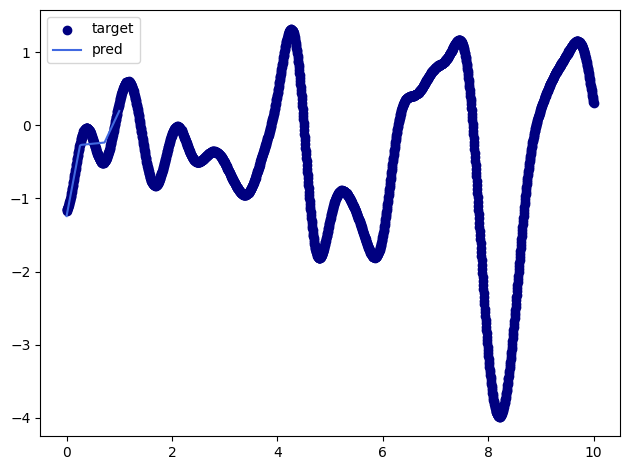

In [129]:
Var = lambda x, dtype=torch.FloatTensor: Variable(torch.from_numpy(x).type(dtype))
x_ = np.linspace(0,1,1000)
X_ = Var(x_).unsqueeze(1)
pred = net.forward(X_).data.numpy().squeeze(1)

plt.scatter(X, Y, c='navy', label='target')
plt.plot(x_, pred, c='royalblue', label='pred')
plt.legend()
plt.tight_layout()
plt.show()

In [130]:
from torch.utils.data import Dataset, DataLoader
loader = DataLoader(list(zip(X,Y)))

Use the Laplace package on our base NN model to find the Hessian matrix of the weights of the hidden units.

In [131]:
la = Laplace(net, 'regression')
la.fit(loader)

log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in range(1000):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

Directly compute the mean and variance of our prediction based on the hessian matrix and Laplace Approximation method

In [132]:
x_ = torch.from_numpy(np.linspace(0,10,2000).reshape(-1,1)).float()
f_mu, f_var = la(x_)
f_mu = f_mu.squeeze().detach().numpy()
f_sigma = f_var.squeeze().sqrt().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)

Graph the mean and +-2 variance range respectively

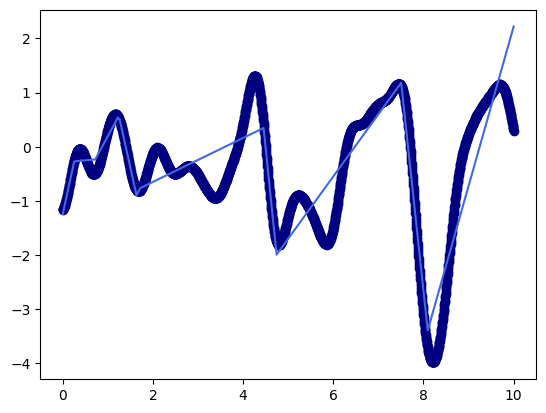

In [133]:
x_ = (np.linspace(0,10,2000))
plt.scatter(X, Y, c='navy', label='target')
plt.plot(x_, f_mu, c='royalblue', label='mean pred')

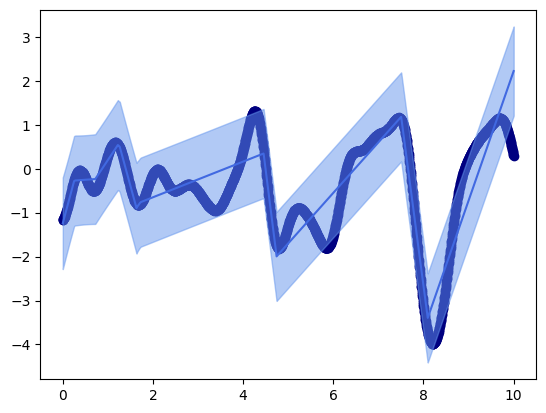

In [134]:
x_ = (np.linspace(0,10,2000))
plt.scatter(X, Y, c='navy', label='target')
plt.plot(x_, f_mu, c='royalblue', label='mean pred')
plt.fill_between(x_, f_mu-2*pred_std, f_mu+2*pred_std, color='cornflowerblue', alpha=.5, label='+/- 2 std')